# Notebook to develop the model for the project

## Imports

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tqdm import tqdm
import PIL
import os
from IPython.display import clear_output

#for all the plots to be inline
%matplotlib inline 


## Custom Dataset Class

In [2]:
'''
reads data from the plot folder and loads into GPU memory
'''
class plot_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform, data_batch, data_index, device='cuda:0'):
        self.df = pd.read_csv(csv_path, skiprows=data_index*data_batch, nrows=data_batch)
        self.images_folder = images_folder
        self.transform = transform
        self.image_list = torch.empty(len(self.df.values), 1, 96, 96, dtype=torch.float32)
        self.label_list = torch.empty(len(self.df.values), 8, dtype=torch.float32)
        
        for i in tqdm(range(len(self.df.values))):
            filename = self.df.values[i][0]
            labels = np.array([0., 0., 0., 0., 0., 0., 0., 0.])
            labels = torch.from_numpy(labels)
            for x in range(0, 8):
                labels[x] = self.df.values[i][x+1]
            labels = labels.to(device)
            self.label_list[i] = labels
            image = PIL.Image.open(os.path.join(self.images_folder, filename))
            if self.transform is not None:
                image = self.transform(image)
            images = image.to(device)
            self.image_list[i] = images
        
    def __len__(self):
        return len(self.df)
            
    def __getitem__(self, index):
        image = self.image_list[index]
        labels = self.label_list[index]
        
        return image, labels

In [ ]:
'''
    Creating a measure of accuracy for our network
    based on the RMSE 
'''
# Measure of accuracy
class Measure_Acc(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predicted, target):
        rmse = torch.sqrt(self.mse(predicted, target))
        rmse_norm = rmse /  20. # normalization 20 = 10 - (-10)
        # print('rmse normal =', rmse_norm)
        accuracy = 100 * (1 - rmse_norm)
        return accuracy

rmse_accuracy = Measure_Acc()

## Set GPU (cuda:0) to Device to Be Used

In [3]:
'''Selecting Device to run on'''
# Select device to train on
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
# device = 'cpu' # force device to be cpu

cuda:0


## Neural Network Class

In [ ]:
'''
    Model built from scratch
'''
class PolyCurveDetector(nn.Module):
    def __init__(self, lr, batchsize, num_head, num_epochs, ):
        super(PolyCurveDetector, self).__init__()
         # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
        self.embed_dim = 0
        self.num_head = 0
        self.n_input = 1568 # the output of maxpool 96*96 
        #DONE:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.criterion = nn.MSELoss() 

        self.attention = nn.Sequential(
            nn.MultiheadAttention(self.embed_dim, self.num_head)
        )
    
        self.convs = nn.Sequential(
            nn.Conv2d(1, 8, 3), # convolution2dLayer(3,8,'Padding','same')
            nn.BatchNorm2d(8),   # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
            nn.Conv2d(8, 16, 3), # convolution2dLayer(3,16,'Padding','same')
            nn.BatchNorm2d(16), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
            nn.Conv2d(16, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.BatchNorm2d(32), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
            nn.BatchNorm2d(32), # batchNormalizationLayer
            nn.LeakyReLU(), # reluLayer
            nn.MaxPool2d(2, 2) # Max pooling layer
        )

       
        self.linear = nn.Sequential(
            nn.Linear(self.n_input,  4096),
            nn.LeakyReLU(),
            nn.Dropout(p=.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(),
            nn.Dropout(p=.3),
            nn.Linear(4096, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=.1),
            nn.Linear(64, self.n_output),
            nn.LeakyReLU()
        )


    def forward(self, input):
        '''feedword pass through our network'''
        input = self.convs(input)
        input = self.view(input.shape[0], -1) #flatten the input tensor
        input = self.linear(input)
        
        return input

    def train(self, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
        '''
        Defining the validation and train
        functions for training phase
        '''
        steps = 0
        running_loss = 0
        test_losses = []
        train_losses = []
        for e in range(epochs):
            # Model in training mode, dropout is on
            model.train()
            for images, labels in trainloader:
                steps += 1
                # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
                # Flatten images into a 784 long vector
                # images = images.view(images.shape[0], -1)
                labels = labels.float()
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                
                output = self.forward(images)
                # print(f'output={output.shape}')
                # print(f'label={labels.shape}')
                loss = criterion(output, labels)
                loss.backward() # computes gradient and backpropagation
                optimizer.step() # update of weights and biases happenss
                
                running_loss += loss.item()

                if steps % print_every == 0:
                    # Model in inference mode, dropout is off
                    model.eval()
                    
                    # Turn off gradients for validation, will speed up inference
                    with torch.no_grad():
                        test_loss, accuracy = self.validation(testloader, criterion)
                    
                    train_losses.append(running_loss/print_every)
                    test_losses.append(test_loss.to('cpu')/len(testloader))

                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                        "Accuracy: {:.3f}".format(accuracy/len(testloader))
                        )
                    
                    running_loss = 0
                    
                    # Make sure dropout and grads are on for training
                    model.train()

        # Plotting the losses
        #plt.ylim([0, 50])          
        #plt.plot(train_losses, label='Training loss')
        #plt.plot(test_losses, label='Validation loss')
        #plt.legend(frameon=False)         
        return train_losses, test_losses
      

    
    def validation(self, testloader, criterion):
        '''
        Defining the validation and train
        functions for training phase
        '''
        accuracy = 0
        test_loss = 0
        for images, labels in testloader:
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)

            output = self.forward(images)

            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            test_loss += criterion(output, labels)
            accuracy += rmse_accuracy(output, labels)

        return test_loss, accuracy

    def save_checkpoint(self, path):
        checkpoint = {
            'model': self.to(torch.device('cpu')),
            'state_dict': self.state_dict(),
        }
        torch.save(checkpoint, path)
        
    def load_checkpoint(path):
        '''give absolute path'''
        checkpoint = torch.load(path)
        model = checkpoint['model']
        model.load_state_dict(checkpoint['state_dict'])

        return model


In [ ]:

model = PolyCurveDetector() 

### Variable Definition and Setup

In [8]:

checkpoint_path = 'C:\\Users\\the_3\\Desktop\\College\\Fall2021\\AI\\poly-curve-detector\\models\\model_checkpoint.pth'
BATCHSIZE = 128
transform = transforms.Compose([
    # 3 grey channels because of DenseNet
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
])

# define total amount of data to load in memory and which section of csv file to select from
# index 0 is the first n elements where n is data_batchsize, index 1 is the second n elements, etc

data_index = 0
training_batchsize = 768
testing_batchsize = 128

root = "D:\\Downloads\\plotData"

test_losses = []
train_losses = []
newTraining_losses = []
newTest_losses = []


LEARNING_RATE = .001
EPOCHS = 10
LOSS_FN = nn.MSELoss()
OPTIMIZER = optim.Adam(
    model.parameters(), 
    lr= LEARNING_RATE
)

model.to(device)

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

### For Running Additional Epochs on the Loop Without Restarting

In [11]:
data_index = 0
EPOCHS = 40

### Training Loop Driver Code

Epoch: 1/10..  Training Loss: 17.112..  Test Loss: 15.216..  Accuracy: 80.499
Epoch: 2/10..  Training Loss: 16.882..  Test Loss: 15.356..  Accuracy: 80.412
Epoch: 3/10..  Training Loss: 16.571..  Test Loss: 15.088..  Accuracy: 80.583
Epoch: 4/10..  Training Loss: 16.264..  Test Loss: 15.133..  Accuracy: 80.553
Epoch: 5/10..  Training Loss: 15.974..  Test Loss: 15.138..  Accuracy: 80.550
Epoch: 5/10..  Training Loss: 15.728..  Test Loss: 14.953..  Accuracy: 80.669
Epoch: 6/10..  Training Loss: 15.347..  Test Loss: 14.990..  Accuracy: 80.644
Epoch: 7/10..  Training Loss: 15.559..  Test Loss: 15.379..  Accuracy: 80.394
Epoch: 8/10..  Training Loss: 15.223..  Test Loss: 15.390..  Accuracy: 80.391
Epoch: 9/10..  Training Loss: 17.993..  Test Loss: 17.145..  Accuracy: 79.301
Epoch: 10/10..  Training Loss: 16.690..  Test Loss: 16.514..  Accuracy: 79.687
Epoch: 10/10..  Training Loss: 15.707..  Test Loss: 15.581..  Accuracy: 80.270


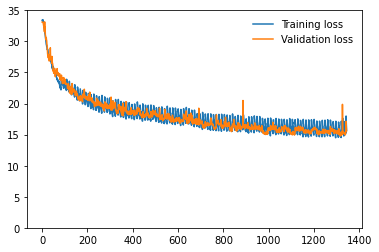

In [9]:
# if you get errors rerunning this, data_index likely didn't get reset to 0 (located in previous cell)
# number in range is how many times to run the loop
# total_batches * data_batchsize * number in range = total amount of data covered
# 10 * 768 * 113 = about 874146 (total training dataset size)
# 10 * 128 * 117 = about 149856 (total testing dataset size)
# subtract 1 from number in range since it starts at 0
# max number in range can be 112 to prevent error
#
for x in range(112):
    trainDataset = plot_dataset(
        root + "\\labels\\trainPlots.csv",
        root + "\\trainPlots", transform,
        training_batchsize, data_index
    )

    testDataset = plot_dataset(
        root + "\\labels\\testPlots.csv",
        root + "\\testPlots", transform,
        testing_batchsize, data_index
    )

    data_index += 1

    #iteratively load small chunks of the dataset
    #total_batches set to (number to be updated) should cover the entire dataset
    #(number to be updated) takes up about 13GB of RAM
    total_batches = 10 
    while data_index < (total_batches * (x+1)):
        newTrainDataset = plot_dataset(
            root + "\\labels\\trainPlots.csv",
            root + "\\trainPlots", transform,
            training_batchsize, data_index
        )

        newTestDataset = plot_dataset(
            root + "\\labels\\testPlots.csv",
            root + "\\testPlots", transform,
            testing_batchsize, data_index
        )
    
        trainDataset += newTrainDataset
        testDataset += newTestDataset
    
        data_index += 1
        clear_output(wait=True)
        
    BATCHSIZE = 128
    train_set = torch.utils.data.DataLoader(
        trainDataset, 
        shuffle=True, 
        batch_size=BATCHSIZE
    )
    test_set = torch.utils.data.DataLoader(
        testDataset, 
        shuffle=False, 
        batch_size=BATCHSIZE
    )
      
    #isFile = os.path.isfile(checkpoint_path)
        
    #if(isFile):
        #model = load_checkpoint(checkpoint_path)
        
    #model.to(device)
    
    #print(train_losses, test_losses, newTraining_losses, newTest_losses)
        
    newTraining_losses, newTest_losses = train(
        model=model, 
        trainloader=train_set, 
        testloader=test_set, 
        criterion=LOSS_FN,
        optimizer= OPTIMIZER,
        epochs=EPOCHS, 
        print_every=60
    )
    
    train_losses += newTraining_losses
    test_losses += newTest_losses
    
    #save_checkpoint(checkpoint_path)
    
    del trainDataset, testDataset, newTrainDataset, newTestDataset
    
plt.ylim([0, 35])          
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Test Network after training

test accuracy: 79.42577362060547
Output tensor: [ 4.7266006   5.8930035  -5.2037773  -0.84141815 -2.8824108  -1.7704996
 -0.92547596 -7.4324894 ]
Output curve: 


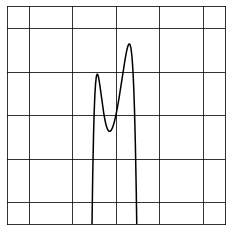

Actual label tensor: [ 5.15  7.68 -7.39 -8.26 -3.37 -5.64 -6.08 -8.05]
Actual curve: 


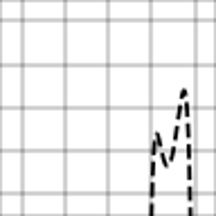

In [47]:
'''Testing the trained network'''
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

imagenum = 2

output = model.forward(img)
#print(output)
#print(lbls)

print(f'test accuracy: {rmse_accuracy(output, lbls)}')

x = np.linspace(-5, 5, 1000)

output0_coeff = output[imagenum]
output0_coeff = output0_coeff.detach().cpu().numpy()
lbls0_coeff = lbls[imagenum]
lbls0_coeff = lbls0_coeff.detach().cpu().numpy()

fileName = ''
for l in range(0, 8):
    if lbls0_coeff[l] >= 0:
        fileName = 'p' + str(lbls0_coeff[l]) + fileName
    else:
        fileName = 'n' + str(abs(lbls0_coeff[l])) + fileName
            
fileIteration = 0
fileName = fileName + '_' +str(fileIteration) + '.png'
folderPath = 'E:\\GitHub\\poly-curve-detector\\data\\plotData\\testPlots\\'
filePath = folderPath + fileName
actualimg = PIL.Image.open(filePath)
actualimg = actualimg.resize((216, 216))

#actualimg = img[imagenum]
#actualimg = actualimg.detach().cpu().numpy()
#actualimg = np.squeeze(actualimg, axis=0)

fig, ax = plt.subplots()

#display output[0] curve
print(f'Output tensor: {output0_coeff}')
print('Output curve: ')
ax.plot(x, 
    (
        (output0_coeff[7]*x**8) + (output0_coeff[6]*x**7) +
        (output0_coeff[5]*x**6) + (output0_coeff[4]*x**5) +
        (output0_coeff[3]*x**4) + (output0_coeff[2]*x**3) + 
        (output0_coeff[1]*x**2) + (output0_coeff[0]*x**1)
    ),color='#000000')
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(
    left = False, 
    labelleft = False,
    bottom =  False, 
    labelbottom = False
)
ax.grid(color='#000001')

plt.show()

#display actual curve
print(f'Actual label tensor: {lbls0_coeff}')
print('Actual curve: ')
#fig, ax = plt.subplots()

#ax.plot( x, 
#    (
#        (lbls0_coeff[7]*x**8) + (lbls0_coeff[6]*x**7) +
#        (lbls0_coeff[5]*x**6) + (lbls0_coeff[4]*x**5) + 
#        (lbls0_coeff[3]*x**4) + (lbls0_coeff[2]*x**3) + 
#        (lbls0_coeff[1]*x**2) + (lbls0_coeff[0]*x**1)
#    ), color='#000000')
    
#ax.set_xlim(-5, 5)
#ax.set_ylim(-5, 5)
#ax.set_aspect('equal', adjustable='box')
#ax.tick_params(
#    left = False, 
#    labelleft = False,
#    bottom =  False, 
#    labelbottom = False
#)
#ax.grid(color='#000001')

#plt.show()

display(actualimg)